In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'StanfordCS/CS231n/Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

%load_ext autoreload
%autoreload 2

%pip install thop

models_dir = 'LabNet/models/'
img_dir = 'Plots/'

Mounted at /content/drive
/content/drive/My Drive/StanfordCS/CS231n/Project


# DataSets


In [2]:
# DataSet creation
import LabNet.data
from LabNet.data import *
from collections import Counter
import torchvision
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using ' + str(device).upper())
print()

### TEST SET ###
test_set = datasets.ImageFolder('DataSet/Test', transform=test_transform())
test_set_size = test_set.__len__()
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_set_size, shuffle=False)

### OPEN TEST SET ###
open_test_set = datasets.ImageFolder('DataSet/OpenTest', transform=test_transform())
open_test_set_size = open_test_set.__len__()
open_test_loader = torch.utils.data.DataLoader(open_test_set, batch_size=open_test_set_size, shuffle=False)

### TRAIN / VAL SETS ###
train_split = 0.8 # val_split=1-train_split
data = create_datasets(train_split, 'DataSet/Train')

# Data is imbalanced, make custom sampler - see sanity check below
train_weights = get_sampler_weights(data['train'], verbose='True')
val_weights = get_sampler_weights(data['val'], verbose='True')
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, len(train_weights))
val_sampler = torch.utils.data.sampler.WeightedRandomSampler(val_weights, len(val_weights))

Using CUDA



In [3]:
# split out loaders so we can play with batch without rerunning previous cell
train_batch_size = 32
train_loader = torch.utils.data.DataLoader(
    data['train'], 
    batch_size=train_batch_size, 
    sampler=train_sampler, 
    # shuffle=True, # sampler provided
    drop_last=False)

val_batch_size = data['val'].__len__() # note it does *not* load the whole val set since we use weighted sampling 
val_loader = torch.utils.data.DataLoader(
    data['val'], 
    batch_size=val_batch_size, 
    sampler=val_sampler)

num_classes = len(data['full'].classes)
classes, class_to_idx, idx_to_class = find_classes()
print('Number of classes: {}'.format(num_classes))
print('Classes: ', class_to_idx)
print('Class count: ', dict(Counter(data["full"].targets)))
print('Full set size {}'.format(len(data['full'])))
print('Train set size: {}'.format(len(data['train'])))
print('Val set size {}'.format(len(data['val'])))
print('Test set size {}'.format(test_set_size))
print('Open test set size {}'.format(open_test_set_size))

Number of classes: 12
Classes:  {'Cuillean': 0, 'Ellie': 1, 'Fionn': 2, 'Keaton': 3, 'Mochi': 4, 'new_Finley': 5, 'new_Maya': 6, 'new_Remington': 7, 'new_Riley': 8, 'new_Sammy': 9, 'new_Theo': 10, 'new_Tomy': 11}
Class count:  {0: 20, 1: 20, 2: 20, 3: 20, 4: 95, 5: 20, 6: 25, 7: 33, 8: 23, 9: 34, 10: 20, 11: 20}
Full set size 350
Train set size: 280
Val set size 70
Test set size 120
Open test set size 42


## Visualize and sanity-check the datasets

View some images from the dataset. Train applies transforms, Val/Test do not. Train/Val sample with weighting, Test is already equally weighted.

Class labels:  tensor([ 6,  3, 10,  7])


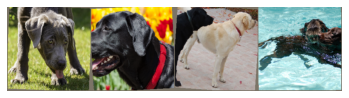

In [ ]:
from LabNet.eval_utils import *
loader = train_loader

# Get a batch of training data
images, classes = next(iter(loader))
images = images[:4]
out = torchvision.utils.make_grid(images)
show_images(out)
print('Class labels: ', classes[:len(images)])

# # Can activate grayscale in test_transform() to check it's working 
# inputs, classes = next(iter(val_loader))
# out = torchvision.utils.make_grid(inputs)
# imshow(out)#, title=[class_names[x] for x in classes])

# # wrong - the image is normalized 2x but not unnormalized
# index = 85
# img, _ = data['full'][index]
# plt.imshow((preprocess(img)[0]).numpy().transpose((1, 2, 0)))

Check (weighted) sampler works as expected


In [ ]:
# class_samples should be roughly uniform
loader = val_loader

classes, class_to_idx = find_classes()
num_classes = len(classes)
class_samples = np.zeros(num_classes)

for trials in range(2):
  for _, label in loader:
    for i in range(num_classes):
      class_samples[i] += (label.numpy() == i).sum()

print('Number of items sampled:')
print(class_samples)

ValueError: ignored

# Classifier


## Model set-up

In [136]:
import torchvision.models as models
import LabNet.model
from LabNet.model import *

model = models.vgg16(pretrained=True)
print('Full VGG-16')
print(model)
print()

use_fc1 = True
p=0.75
if use_fc1:
  set_as_fc1_classifier(model, num_classes, p=p)
else:
  h_size=128
  set_as_fc2_classifier(model, h_size, num_classes=num_classes, p=p)

model.to(device)
print('New classifier layer:')
print(model.classifier)

print()
nparams = get_num_trainable_params(model)
print('Model has {} trainable parameters'.format(nparams))
# print('Check: FC2 model size: {}'.format((4096+1)*h_size +(h_size+1)*num_classes))

flops, params = profile_model(model, False, device)
print('Total model params: {} FLOPs: {}'.format(params, flops))

Full VGG-16
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

# I. Classification
## Train loop


In [ ]:
from LabNet.train import *

# train from scratch to have nicer learning curves
if use_fc1:
  model.classifier[6].reset_parameters() 
else:
  model.classifier[3].reset_parameters()
  model.classifier[6].reset_parameters()

# data
d_loaders = {}
d_loaders['train'] = train_loader
d_loaders['val'] = val_loader

# loss
loss_fct = torch.nn.CrossEntropyLoss()

# optimizer
params_to_update = get_params_to_update(model, verbose=True)
lr = 1e-3
wd = 1e-1
optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=wd) #lr=1e-3, weight_decay=5e-3

# train the model
num_epochs = 20
model, val_acc, tlh, vlh, tah, vah = train_model(model
                                                 ,d_loaders
                                                 ,loss_fct 
                                                 ,optimizer 
                                                 ,num_epochs 
                                                 ,device
                                                 ,verbose=True
                                                 )

# gradients no longer used (for now)
torch.no_grad()

Params to learn:
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/19
----------
(Iteration 1 / 180) loss: 2.820086 acc: 0.125000
(Iteration 2 / 180) loss: 2.478012 acc: 0.250000
(Iteration 3 / 180) loss: 2.788188 acc: 0.125000
(Iteration 4 / 180) loss: 2.676530 acc: 0.093750
(Iteration 5 / 180) loss: 2.718058 acc: 0.187500
(Iteration 6 / 180) loss: 2.604753 acc: 0.093750
(Iteration 7 / 180) loss: 2.705288 acc: 0.093750
(Iteration 8 / 180) loss: 2.553392 acc: 0.218750
(Iteration 9 / 180) loss: 2.303704 acc: 0.125000
train Loss: 2.6368 Acc: 0.1464
val Loss: 1.8434 Acc: 0.4143

Epoch 1/19
----------
(Iteration 10 / 180) loss: 2.709307 acc: 0.125000
(Iteration 11 / 180) loss: 2.126461 acc: 0.187500
(Iteration 12 / 180) loss: 2.230594 acc: 0.250000
(Iteration 13 / 180) loss: 2.034410 acc: 0.281250
(Iteration 14 / 180) loss: 1.639887 acc: 0.437500
(Iteration 15 / 180) loss: 2.226919 acc: 0.250000
(Iteration 16 / 180) loss: 1.997856 acc: 0.156250
(I

Plot training history

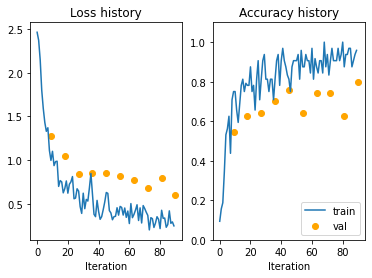

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(121)
plt.title('Loss history')
plt.plot(tlh)
# val is on a different batch_size, data_size
scaled_axis = (1+np.array(range(len(vlh)))) * int(len(tlh)/len(vlh))
plt.scatter(scaled_axis, vlh, c='orange')
plt.xlabel('Iteration')
# plt.ylabel('Loss')

plt.subplot(122)
plt.title('Accuracy history')
plt.plot(tah, label='train')
plt.scatter(scaled_axis, vah, c='orange', label='val')
plt.xlabel('Iteration')
plt.ylim([0, 1.1])
# plt.ylabel('Accuracy')
plt.legend()


name = 'cl_acc_0' + str(int(val_acc*100)) + '_p'+str(int(p*100)) + '_lr'+str(int(lr*10000)) + '_wd'+str(int(wd*100))
if use_fc1:
  name = name + '_fc1'
else:
  name = name + '_h'+str(h_size) + '_fc2'

imgpath = img_dir + name + '.png'
plt.savefig(imgpath)

plt.show()

Save model to disk

In [ ]:
# save this model to disk and o/r previous ?
save_to_disk = False

if save_to_disk:
  name = 'cl_acc_0' + str(int(val_acc*100)) + '_p'+str(int(p*100)) + '_lr'+str(int(lr*10000)) + '_wd'+str(int(wd*100))
  if use_fc1:
    name = name + '_fc1'
  else:
    name = name + '_h'+str(h_size) + '_fc2'
  
  path = models_dir + name + '.pt'
  torch.save(model, path) 
  print('Model saved successfully: {}'.format(name))

  imgpath = img_dir + name + '.png'
  plt.savefig(imgpath)

## Classifier evaluation

### Confusion matrix

In [5]:
# Accuracy and confusion matrix on Test set
load_from_disk = True
if load_from_disk:
  path = models_dir + 'cl_acc_084_p300_lr10_wd10_h128_fc2.pt'
  model = torch.load(path, map_location=torch.device(device))
  model.eval()

confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
  for i, (imgs, classes) in enumerate(test_loader):
    imgs = imgs.to(device)
    classes = classes.to(device)
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)

    fails = (classes==preds)

    for t, p in zip(classes.view(-1), preds.view(-1)):
      confusion_matrix[t.long(), p.long()] += 1

acc = np.sum(np.diagonal(confusion_matrix))/np.sum(confusion_matrix)
print('Test set accuracy: {}'.format(acc))
print()
print('Confusion matrix:')
print(confusion_matrix)

Test set accuracy: 0.7333333333333333

Confusion matrix:
[[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  8.  0.  0.  0.  0.  1.  1.  0.  0.  0.]
 [ 0.  2.  0.  5.  0.  2.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  9.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.  6.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  9.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  9.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.  0.  6.  0.  0.]
 [ 1.  0.  2.  0.  2.  0.  0.  0.  0.  0.  5.  0.]
 [ 0.  3.  0.  2.  0.  1.  0.  0.  0.  0.  0.  4.]]


### Visualize predictions

Incorrect predictions





Incorrect: 32 / 120
[5, 5, 5, 8, 7, 5, 5, 9, 1, 1, 8, 3, 3, 3, 9, 7, 2, 7, 7, 7, 7, 2, 2, 0, 4, 4, 3, 1, 1, 1, 5, 3]

Correct: 88 / 120
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11]



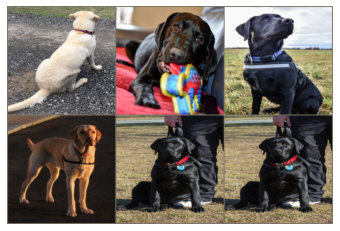

In [6]:
from LabNet.eval_utils import *

images, labels = next(iter(test_loader))
images = images.to(device)
out = model(images)
_, preds = torch.max(out, 1)

num_preds = len(labels)
wrong_preds = []
right_preds = []
wrong_imgs = []
right_imgs = []
wrong = 0
for i in range(num_preds):
  if preds[i] != labels[i]:
    wrong_preds.append(preds[i].item())
    wrong_imgs.append(images[i])
    wrong += 1
  else:
    right_preds.append(preds[i].item())
    right_imgs.append(images[i])

print('Incorrect: {} / {}'.format(wrong, num_preds))
print([x for x in wrong_preds])
print()

print('Correct: {} / {}'.format(num_preds-wrong, num_preds))
print([x for x in right_preds])
print()

# wrongly classified images
num_display = 3
wrong_imgs = torch.cat(wrong_imgs)
wrong_imgs = torch.reshape(wrong_imgs, (-1, 3, 224, 224))

# examples of true images from the wrongly predicted class
start = 10

true_img_examples = []
for i in wrong_preds[start: start+num_display]:
  true_img_examples.append(images[labels.tolist().index(i)])

true_img_examples = torch.cat(true_img_examples)
true_img_examples = torch.reshape(true_img_examples, (-1, 3, 224, 224))

img_display = torch.cat([wrong_imgs[start: start+num_display], true_img_examples])
img_display = torch.reshape(img_display, (-1, 3, 224, 224))

# out = torchvision.utils.make_grid(wrong_imgs[:num_display].cpu(), nrow=2)
out = torchvision.utils.make_grid(img_display.cpu(), nrow=num_display)
show_images(out)

Saliency

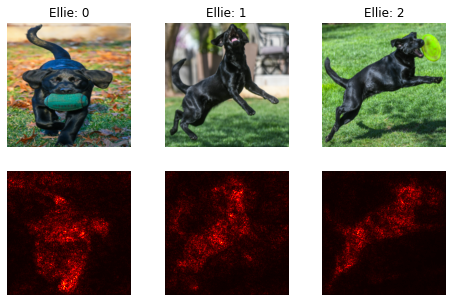

In [ ]:
from LabNet.eval_utils import *
model = load_model('cl_valacc_0100_p75_h128_fc2.pt', device)

X = images[10:13]
y = labels[10:13].to(device)

show_classifier_saliency_maps(X, y, model, idx_to_class)

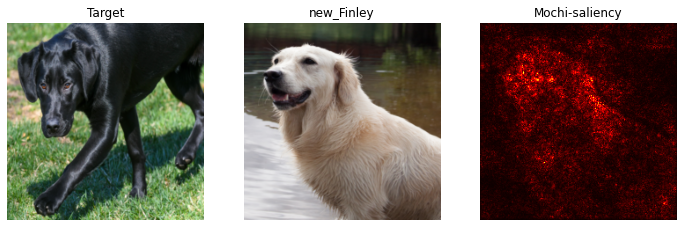

In [19]:
from LabNet.eval_utils import *

X1 = images[0:1]
X2 = images[13:14]
y = labels[55:56]

show_verifier_saliency_maps(X1, X2, y, model, idx_to_class)

# II. Verification


Feature extraction - remove classification layer from model

In [130]:
# load set
loader = open_test_loader

imgs, classes = next(iter(loader))
imgs = imgs.to(device)
classes = classes.to(device)
print('#imgs: {}'.format(len(imgs)))

# images should be grouped by class for the matrix heat-map to be useful
orig = list(classes.cpu().numpy())
srtd = list(classes.cpu().numpy())
srtd.sort(reverse=False)

if orig != srtd:
  print('Sorting images first')
  newlist=sorted(zip(imgs, classes.cpu().numpy()), key=lambda x: x[1], reverse=False)
  imgs, classes = zip(*newlist)
  sorted_imgs = torch.cat(imgs, dim=0).view([len(imgs), 3, 224, 224])
  imgs = sorted_imgs.to(device)

#imgs: 42


In [131]:
from LabNet.model import *
# fitted Classifier model
model_cl = load_model('cl_acc_084_p300_lr10_wd10_h128_fc2.pt', device)

# remove classification layer from the model
print('Original classifier:')
print(model_cl.classifier)
print()

model_cl = remove_class_layer(model_cl)
print('Feature model:')
print(model_cl.classifier)
print()

# sanity check : quasi-blank model
model_bl = models.vgg16(pretrained=False)
set_as_fc2_feature_model(model_bl, h_size=128, p=0.75)
model_bl.to(device)

# sanity check : unfitted model
model_sc = models.vgg16(pretrained=True)
set_as_fc2_feature_model(model_sc, h_size=128, p=0.75)
model_sc.to(device)
print('SC feature model:')
print(model_sc.classifier)
print()

nparams = get_num_trainable_params(model_sc)
print('Model has {} trainable parameters'.format(nparams))
# print('Check: FC2 model size: {}'.format((4096+1)*h_size +(h_size+1)*num_classes))

flops, params = profile_model(model_sc, False, device)
print('Total model params: {} FLOPs: {}'.format(params, flops))

Original classifier:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.75, inplace=False)
  (3): Linear(in_features=4096, out_features=128, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.75, inplace=False)
  (6): Linear(in_features=128, out_features=12, bias=True)
)

Feature model:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.75, inplace=False)
  (3): Linear(in_features=4096, out_features=128, bias=True)
)

SC feature model:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.75, inplace=False)
  (3): Linear(in_features=4096, out_features=128, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.75, inplace=False)
  (6): Linear(in_features=128, out_features=128, bias=True)
)

Model has 540928 trainable parameters
Total model params: 118.02M FLOPs: 18.10G


F.shape: torch.Size([42, 128])
dist.shape: (42, 42)


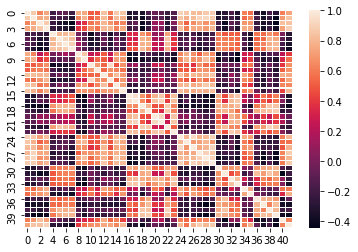

@d=0.1 VAL=1.00 FAR=0.50
@d=0.2 VAL=1.00 FAR=0.48
@d=0.3 VAL=1.00 FAR=0.45
@d=0.4 VAL=1.00 FAR=0.41
@d=0.5 VAL=1.00 FAR=0.37
@d=0.6 VAL=0.95 FAR=0.29
@d=0.7 VAL=0.81 FAR=0.19
@d=0.8 VAL=0.48 FAR=0.11
@d=0.9 VAL=0.14 FAR=0.01


In [132]:
from LabNet.eval_utils import *
# choose model_sc: heat map should be somewhat uniform
# choose model_cl: heat map should show bright diagonal

model_temp = model_cl
display_similarity_heatmap(model_temp, imgs)

F = model_temp(imgs)
N = len(classes)
dist = cosine_similarity(F).detach().cpu().numpy()

# true_matrix equals one if images i,j match
true_matrix = (classes == classes.repeat(N).view(N,N).T).cpu().numpy().astype(int)

cl_val = []
cl_far = []
for d in np.linspace(0.1, 0.9, 9):
  val, far, _ = val_far(d, dist, true_matrix)
  print('@d={:.1f} VAL={:.2f} FAR={:.2f}'.format(d, val, far))
  cl_val.append(val)
  cl_far.append(far)

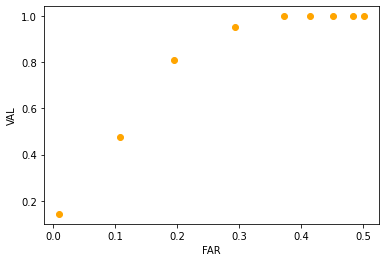

In [133]:
plt.figure()
#plt.title('Loss history')
plt.scatter(np.array(cl_far), np.array(cl_val), c='orange')
plt.xlabel('FAR')
plt.ylabel('VAL')

plt.show()

## Train the Verification Loss model


In [127]:
from LabNet.train import *

# model = model_sc
model = copy.deepcopy(model_sc)

model.classifier[3].reset_parameters()
model.classifier[6].reset_parameters()

# data
d_loaders = {}
d_loaders['train'] = train_loader
d_loaders['val'] = val_loader

# loss
loss_fct = verif_loss

# optimizer
params_to_update = get_params_to_update(model, verbose=True)
lr=1e-3
optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=1e-1) #lr=1e-3, weight_decay=5e-3

# train the model
tau = 0.5
num_epochs = 2
model, best_acc, tlh, vlh, tah = train_verification_model(model
                                           ,tau
                                           ,d_loaders
                                           ,loss_fct 
                                           ,optimizer 
                                           ,num_epochs 
                                           ,device
                                           ,verbose=True
                                           )

# gradients no longer used (for now)
torch.no_grad()

Params to learn:
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/1
----------
(Iteration 1 / 18) loss: 3.564182 acc: 0.192927 
(Iteration 2 / 18) loss: 3.393332 acc: 0.279744 
(Iteration 3 / 18) loss: 3.453787 acc: 0.239058 
(Iteration 4 / 18) loss: 3.499534 acc: 0.206267 
(Iteration 5 / 18) loss: 3.342888 acc: 0.441718 
(Iteration 6 / 18) loss: 3.343920 acc: 0.469459 
(Iteration 7 / 18) loss: 3.325121 acc: 0.364369 
(Iteration 8 / 18) loss: 3.395874 acc: 0.415126 
(Iteration 9 / 18) loss: 3.252445 acc: 0.183798 
train Loss: 3.4009 
val Loss: 3.8118 

Epoch 1/1
----------
(Iteration 10 / 18) loss: 3.398139 acc: 0.384124 
(Iteration 11 / 18) loss: 3.364596 acc: 0.263768 
(Iteration 12 / 18) loss: 3.271188 acc: 0.450960 
(Iteration 13 / 18) loss: 3.339541 acc: 0.324796 
(Iteration 14 / 18) loss: 3.330881 acc: 0.374225 
(Iteration 15 / 18) loss: 3.271333 acc: 0.510556 
(Iteration 16 / 18) loss: 3.385598 acc: 0.425216 
(Iteration 17 / 18) loss: 

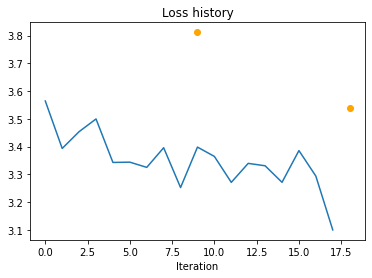

In [128]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()

# plt.subplot(121)
plt.title('Loss history')
plt.plot(tlh)
# val is on a different batch_size, data_size
scaled_axis = (1+np.array(range(len(vlh)))) * int(len(tlh)/len(vlh))
plt.scatter(scaled_axis, vlh, c='orange')
plt.xlabel('Iteration')
# plt.ylabel('Loss')

plt.show()

F.shape: torch.Size([120, 128])
dist.shape: (120, 120)


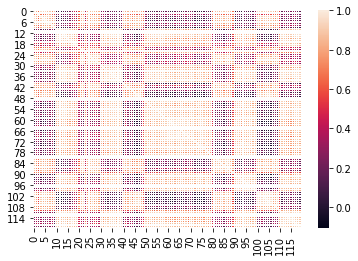

In [129]:
display_similarity_heatmap(model, imgs)

In [52]:
# save this model to disk ?
save_to_disk = False

if save_to_disk:
  name = 'vl_' + str(int(vlh[-1]*10)) + '.pt'

  path = models_dir + name 
  torch.save(model, path) 
  print('Model saved successfully')

Model saved successfully


## VAL and FAR rates


In [123]:
from LabNet.eval_utils import *

F = model(imgs)
N = len(classes)
dist = cosine_similarity(F).detach().cpu().numpy()

# true_matrix equals one if images i,j match
true_matrix = (classes == classes.repeat(N).view(N,N).T).cpu().numpy().astype(int)

for d in np.linspace(0.01, 0.99, 9):
  val, far, _ = val_far(d, dist, true_matrix)
  print('@d={:.1f} VAL={:.2f} FAR={:.2f}'.format(d, val, far))

@d=0.0 VAL=1.00 FAR=0.48
@d=0.1 VAL=1.00 FAR=0.47
@d=0.3 VAL=1.00 FAR=0.47
@d=0.4 VAL=1.00 FAR=0.47
@d=0.5 VAL=0.99 FAR=0.46
@d=0.6 VAL=0.98 FAR=0.46
@d=0.7 VAL=0.98 FAR=0.46
@d=0.9 VAL=0.96 FAR=0.44
@d=1.0 VAL=0.11 FAR=0.01


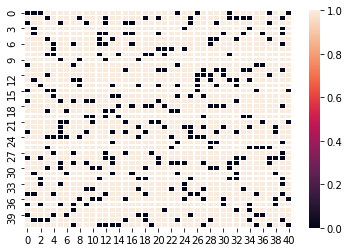

In [59]:
from LabNet.eval_utils import *
# visualize acceptance matrix
d = 0.2
_, _, acceptance_matrix = val_far(d, dist, true_matrix)

display_matrix_heatmap(acceptance_matrix)